In [1]:
# naive prediction model
# uses only elo in a hard coded logic model

import archives_manager

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

In [3]:
# hard-coded logic naive model

def predict_win(archived_game, player_name):
    elo = archives_manager.get_elo(archived_game, player_name)

    if elo['Player'] > elo['Opponent']:
        return 1
    else:
        return 0

In [4]:
def get_opponent_7d_activity(archived_game, player_name):
    opponent_name = archives_manager.get_opponent_name(archived_game, player_name)
    start_unix = archived_game['end_time'] - 7 * 24 * 60 * 60
    end_unix = archived_game['end_time']

    #print("Getting", opponent_name, "games from", start_unix, "to", end_unix)

    try:
        opponent_7d_archive = archives_manager.get_games_between_timestamps(
            opponent_name,
            start_unix,
            end_unix,
            filter_func=archives_manager.build_archive_filter(rated=True, time_class='rapid', exclude_draws=False, max_elo_diff=150)
        )
    except archives_manager.ArchiveRetrievalError as e:
        print("Error occured in retrieving opponent archive", e)
        return None

    return opponent_7d_archive

def get_player_analysis(player_name, num_games):
    recent_archive = archives_manager.get_most_recent_games(player_name, num_games, filter_func=archives_manager.build_archive_filter(rated=True, time_class='rapid', exclude_draws=True, max_elo_diff=150))

    lst = []

    for archived_game in reversed(recent_archive):
        pred = predict_win(archived_game, player_name)
        actual = archives_manager.get_won(archived_game, player_name)

        elo = archives_manager.get_elo(archived_game, player_name)

        accuracy = archives_manager.get_accuracy(archived_game, player_name)

        opponent_7d = get_opponent_7d_activity(archived_game, player_name)

        lst.append({
            'player_elo': elo['Player'],
            'opp_elo': elo['Opponent'],
            'elo_diff': elo['Player'] - elo['Opponent'],
            'opp_7d': len(opponent_7d) if opponent_7d else None,
            'won': actual,
            'won_predict': pred,
            'correct': True if actual == pred else False,
            'player_acc': accuracy['Player'] if accuracy else None,
            'opp_acc': accuracy['Opponent'] if accuracy else None,
            'acc_diff': (accuracy['Player'] - accuracy['Opponent']) if accuracy else None
        })

    df = pd.DataFrame(lst)
    df['ma20'] = df['player_elo'].rolling(window=20).mean()
    df['ma5'] = df['player_elo'].rolling(window=5).mean()
    df['x-ma20'] = df['player_elo'] - df['ma20']
    df['x-ma5'] = df['player_elo'] - df['ma5']
    df['ma5-ma20'] = df['ma5'] - df['ma20']

    return df, recent_archive

In [5]:
def analysis_prediction_stats(df):
    TP = len(df[(df['won_predict'] == 1) & (df['won'] == 1)])
    TN = len(df[(df['won_predict'] == 0) & (df['won'] == 0)])
    FP = len(df[(df['won_predict'] == 1) & (df['won'] == 0)])
    FN = len(df[(df['won_predict'] == 0) & (df['won'] == 1)])

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'N': TP + TN + FP + FN,
        'accuracy': accuracy
    }

In [6]:
num_games_per_player = 1000

players = [
    'BIG_TONKA_T',
    'UnderTheBeer',
    'Dandres0_0'#,
    #'Ale9800',
    #'MrOGH'
]

def get_average_elo(archive, player_name):
    n = len(archive)
    avg = 0

    for archived_game in archive:
        avg += (archives_manager.get_elo(archived_game, player_name)['Player'] / n)

    return avg

analyses = []
stats_list = []

for player_name in players:
    df, recent_archive = get_player_analysis(player_name, num_games=num_games_per_player)
    
    player_info = {
        'Name': player_name,
        'Current Rating': archives_manager.get_elo(recent_archive[0], player_name)['Player'],
        'Average Rating': round(get_average_elo(recent_archive, player_name))
    }

    player_info.update(analysis_prediction_stats(df))

    analyses.append({
        'player_name': player_name,
        'stats': player_info,
        'data': df,
        'archive': recent_archive
    })

    stats_list.append(player_info)

stats_df = pd.DataFrame(stats_list)

overall_average_accuracy = np.mean(stats_df['accuracy'])
print('overall average accuracy', round(overall_average_accuracy, 3))

stats_df

Error occured in retrieving opponent archive Failed to retrieve player Ches_pawns data: 404
overall average accuracy 0.672


,Name,Current Rating,Average Rating,TP,TN,FP,FN,N,accuracy
0,BIG_TONKA_T,1501,1384,369,320,169,142,1000,0.689
1,UnderTheBeer,1424,1343,349,308,178,165,1000,0.657
2,Dandres0_0,1455,1498,351,319,175,155,1000,0.670


In [7]:
for analysis in analyses:
    print(analysis['player_name'])
    print(analysis['data'])

BIG_TONKA_T
     player_elo  opp_elo  elo_diff  opp_7d  won  won_predict  correct  player_acc  opp_acc  acc_diff     ma20     ma5  x-ma20  x-ma5  ma5-ma20
0          1363     1301        62     2.0    1            1     True       91.19    83.09      8.10      NaN     NaN     NaN    NaN       NaN
1          1370     1321        49   280.0    1            1     True       85.17    76.48      8.69      NaN     NaN     NaN    NaN       NaN
2          1377     1328        49    40.0    1            1     True       58.99    58.30      0.69      NaN     NaN     NaN    NaN       NaN
3          1368     1347        21     1.0    0            1    False       71.92    84.37    -12.45      NaN     NaN     NaN    NaN       NaN
4          1360     1360         0    60.0    0            0     True       74.76    73.08      1.68      NaN  1367.6     NaN   -7.6       NaN
5          1367     1319        48    50.0    1            1     True       83.44    74.12      9.32      NaN  1368.4     NaN   -1

In [8]:
# split into correct and incorrect dataframes
data_list = [analysis['data'] for analysis in analyses]
df = pd.concat(data_list)

correct_df = df[df['correct'] == True]
incorrect_df = df[df['correct'] == False]

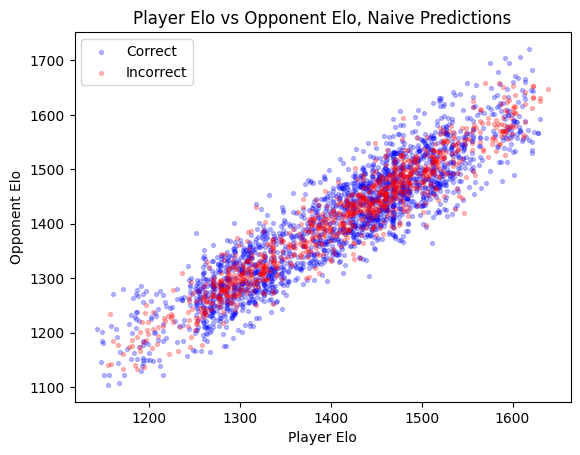

In [9]:
# player vs opponent elo predictions
plt.scatter(correct_df['player_elo'], correct_df['opp_elo'], color='blue', s=8, alpha=0.25, label='Correct')
plt.scatter(incorrect_df['player_elo'], incorrect_df['opp_elo'], color='red', s=8, alpha=0.25, label='Incorrect')

plt.xlabel('Player Elo')
plt.ylabel('Opponent Elo')
plt.title('Player Elo vs Opponent Elo, Naive Predictions')
plt.legend()
plt.show()

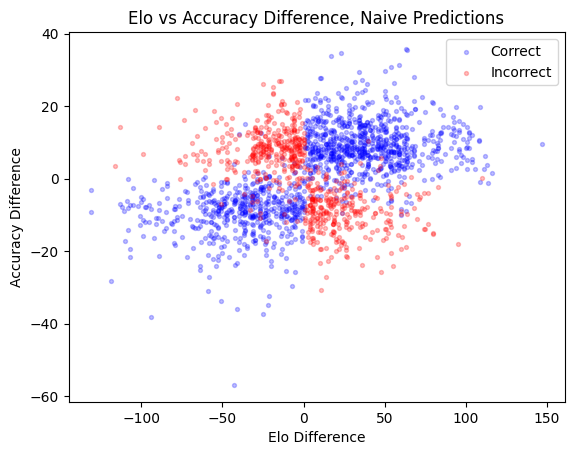

In [10]:
# elo difference vs accuracy difference predictions
plt.scatter(correct_df['elo_diff'], correct_df['acc_diff'], color='blue', s=8, alpha=0.25, label='Correct')
plt.scatter(incorrect_df['elo_diff'], incorrect_df['acc_diff'], color='red', s=8, alpha=0.25, label='Incorrect')

plt.xlabel('Elo Difference')
plt.ylabel('Accuracy Difference')
plt.title('Elo vs Accuracy Difference, Naive Predictions')
plt.legend()
plt.show()

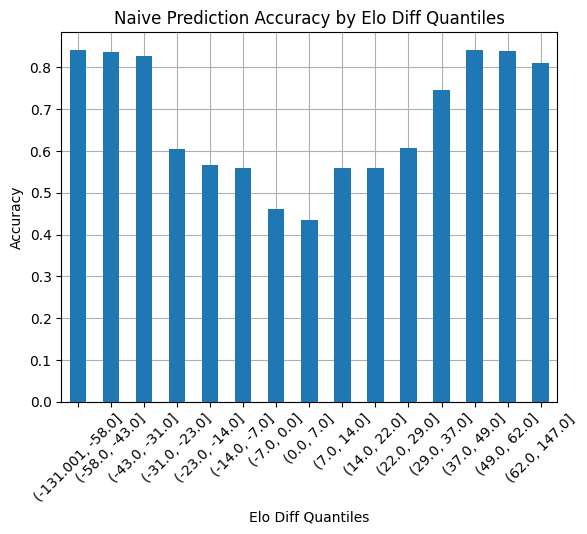

In [11]:
# accuracy by elo difference quantile
num_quantiles = 15
df['quantile'] = pd.qcut(df['elo_diff'], q=num_quantiles)
grouped = df.groupby('quantile', observed=False)['correct'].mean()
grouped.plot(kind='bar', zorder=3)

plt.xlabel('Elo Diff Quantiles')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Naive Prediction Accuracy by Elo Diff Quantiles')
plt.grid(zorder=2)

# Show the plot
plt.show()

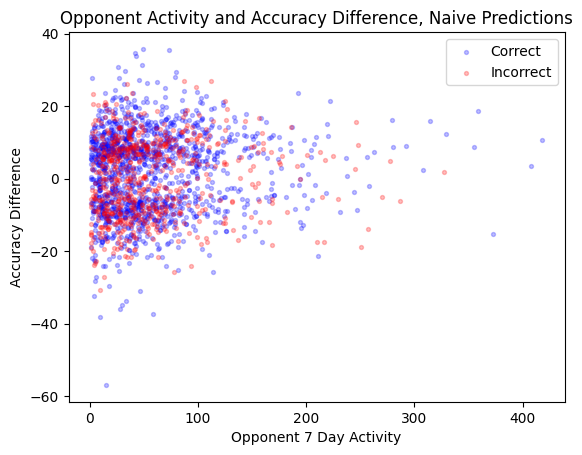

In [12]:
# opponent activity and accuracy difference scatter, naive predictions
plt.scatter(correct_df['opp_7d'], correct_df['acc_diff'], color='blue', s=8, alpha=0.25, label='Correct')
plt.scatter(incorrect_df['opp_7d'], incorrect_df['acc_diff'], color='red', s=8, alpha=0.25, label='Incorrect')

plt.xlabel('Opponent 7 Day Activity')
plt.ylabel('Accuracy Difference')
plt.title('Opponent Activity and Accuracy Difference, Naive Predictions')
plt.legend()
plt.show()


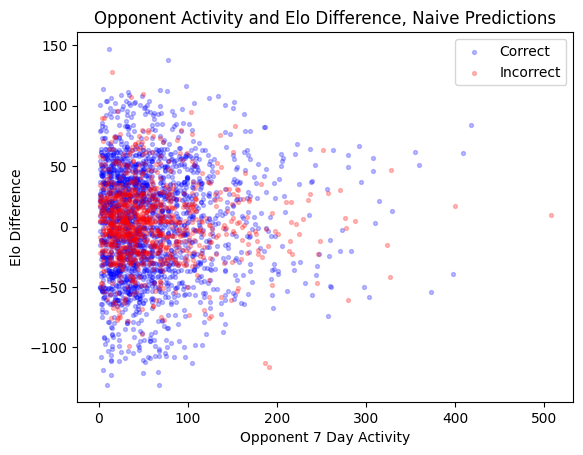

In [13]:
plt.scatter(correct_df['opp_7d'], correct_df['elo_diff'], color='blue', s=8, alpha=0.25, label='Correct')
plt.scatter(incorrect_df['opp_7d'], incorrect_df['elo_diff'], color='red', s=8, alpha=0.25, label='Incorrect')

plt.xlabel('Opponent 7 Day Activity')
plt.ylabel('Elo Difference')
plt.title('Opponent Activity and Elo Difference, Naive Predictions')
plt.legend()
plt.show()

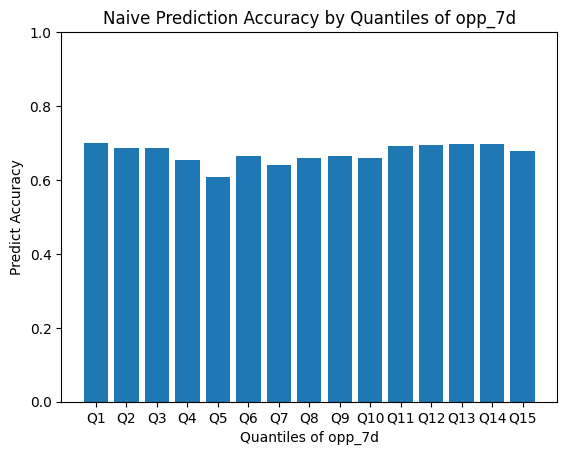

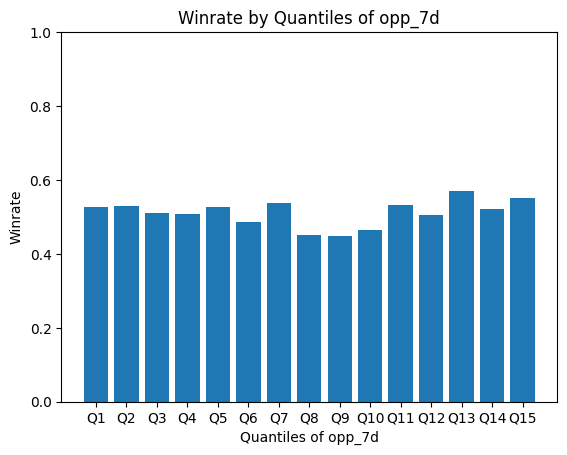

In [25]:
num_quantiles = 15

# Create quantile-based categories
df['quantile_group'] = pd.qcut(df['opp_7d'], q=num_quantiles, labels=[f"Q{i+1}" for i in range(num_quantiles)])

# Calculate mean of 'correct' for each quantile
mean_correct_per_quantile = df.groupby('quantile_group', observed=False)['correct'].mean()

# Plotting
plt.bar(mean_correct_per_quantile.index, mean_correct_per_quantile.values)
plt.xlabel('Quantiles of opp_7d')
plt.ylabel('Predict Accuracy')
plt.ylim(0, 1)
plt.title('Naive Prediction Accuracy by Quantiles of opp_7d')
plt.show()

mean_correct_per_quantile = df.groupby('quantile_group', observed=False)['won'].mean()

plt.bar(mean_correct_per_quantile.index, mean_correct_per_quantile.values)
plt.xlabel('Quantiles of opp_7d')
plt.ylabel('Winrate')
plt.ylim(0, 1)
plt.title('Winrate by Quantiles of opp_7d')
plt.show()

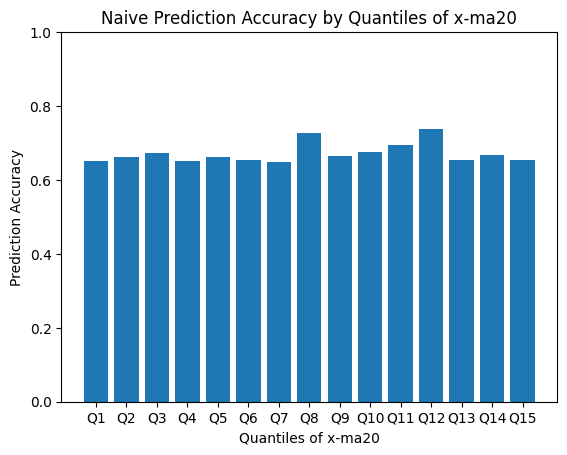

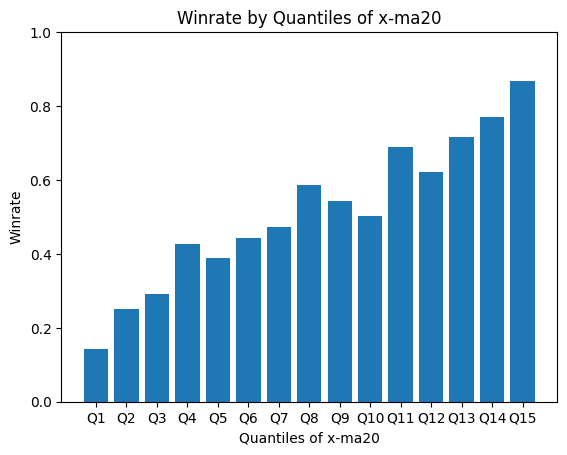

In [26]:
num_quantiles = 15  # for quartiles; adjust as needed

# Create quantile-based categories
df['quantile_group'] = pd.qcut(df['x-ma20'], q=num_quantiles, labels=[f"Q{i+1}" for i in range(num_quantiles)])

# Calculate mean of 'correct' for each quantile
mean_correct_per_quantile = df.groupby('quantile_group', observed=False)['correct'].mean()

# Plotting
plt.bar(mean_correct_per_quantile.index, mean_correct_per_quantile.values)
plt.xlabel('Quantiles of x-ma20')
plt.ylabel('Prediction Accuracy')
plt.ylim(0, 1)
plt.title('Naive Prediction Accuracy by Quantiles of x-ma20')
plt.show()

mean_correct_per_quantile = df.groupby('quantile_group', observed=False)['won'].mean()

# Plotting
plt.bar(mean_correct_per_quantile.index, mean_correct_per_quantile.values)
plt.xlabel('Quantiles of x-ma20')
plt.ylabel('Winrate')
plt.ylim(0, 1)
plt.title('Winrate by Quantiles of x-ma20')
plt.show()

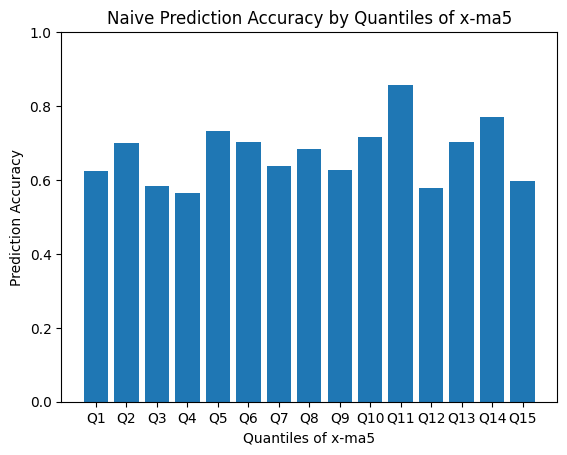

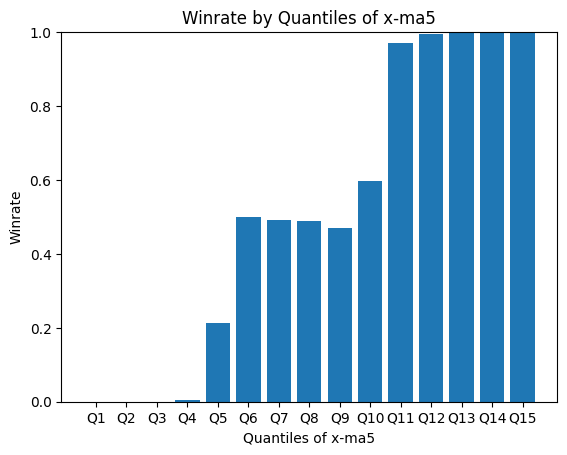

In [27]:
num_quantiles = 15  # for quartiles; adjust as needed

# Create quantile-based categories
df['quantile_group'] = pd.qcut(df['x-ma5'], q=num_quantiles, labels=[f"Q{i+1}" for i in range(num_quantiles)])

# Calculate mean of 'correct' for each quantile
mean_correct_per_quantile = df.groupby('quantile_group', observed=False)['correct'].mean()

# Plotting
plt.bar(mean_correct_per_quantile.index, mean_correct_per_quantile.values)
plt.xlabel('Quantiles of x-ma5')
plt.ylabel('Prediction Accuracy')
plt.ylim(0, 1)
plt.title('Naive Prediction Accuracy by Quantiles of x-ma5')
plt.show()

mean_correct_per_quantile = df.groupby('quantile_group', observed=False)['won'].mean()

# Plotting
plt.bar(mean_correct_per_quantile.index, mean_correct_per_quantile.values)
plt.xlabel('Quantiles of x-ma5')
plt.ylabel('Winrate')
plt.ylim(0, 1)
plt.title('Winrate by Quantiles of x-ma5')
plt.show()